In [306]:
import os
import sys
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [307]:
cwd = os.getcwd()
# Find and import config file
config_path = os.getcwd()

sys.path.append(config_path)
import config

In [308]:
database = config.database
central_banks = config.central_banks
training_data = os.path.join(database, "Training Data")
fed_docs = config.fed_docs
ecb_docs = config.ecb_docs
boe_docs = config.boe_docs

In [309]:
sentiment = pd.date_range(start="1/1/2000", end="1/1/2024", freq="D")
sentiment = pd.DataFrame(sentiment, columns=["date"])

In [310]:
# HP Filter

# url_map = pd.read_csv(os.path.join(cwd, "url_map.csv"))

# for i in range(len(url_map)):
#     if url_map["central bank"][i] == "fed" and url_map["document"][i] == "speeches":
#         speeches = pd.read_csv(url_map["finbert_url"][i])

# speeches["date"] = pd.to_datetime(speeches["date"], format='%Y%m%d')

# fed_speech = speeches.copy(deep=True)

# fed_speech = fed_speech[["date", "sentiment"]]
# fed_speech = fed_speech.rename(columns={"sentiment": "fed_speech_sentiment"})
# fed_speech["date"] = pd.to_datetime(fed_speech["date"])

# fed_speech = fed_speech.resample("Q", on="date").mean().reset_index()

# filter_df = fed_speech.copy(deep=True)
# filter_df = filter_df[["date", "fed_speech_sentiment"]]

# cycle, trend = sm.tsa.filters.hpfilter(filter_df["fed_speech_sentiment"], 1600)

# filter_df["fed_speech_sentiment_cycle"] = cycle
# filter_df["fed_speech_sentiment_trend"] = trend

# filter_df = filter_df[["date", "fed_speech_sentiment_cycle"]]
# fed_speech = fed_speech.drop(columns=["fed_speech_sentiment"])
# filter_df = filter_df.rename(
#     columns={"fed_speech_sentiment_cycle": "fed_speech_sentiment"}
# )
# fed_speech = pd.merge(fed_speech, filter_df, on="date", how="left")
# fed_speech = fed_speech.groupby("date").mean().reset_index()

# sentiment = pd.merge(sentiment, fed_speech, how="left", left_on="date", right_on="date")

In [311]:
url_map = pd.read_csv(os.path.join(cwd, "url_map.csv"))

for i in range(len(url_map)):
    sent = pd.read_csv(url_map["finbert_url"][i])
    sent = sent[["date", "sentiment"]]
    sent = sent.rename(columns={"sentiment": url_map["document"][i]})
    sent["date"] = pd.to_datetime(sent["date"])
    sent = sent.groupby("date").mean().reset_index()

    sentiment = pd.merge(sentiment, sent, how="left", left_on="date", right_on="date")

In [312]:
# Create a summary statistics DataFrame
summary_stats = pd.DataFrame(
    columns=["Variable Name", "Mean", "SD", "Min", "Max", "Num. of Docs."]
)

# List to collect summary statistics
summary_list = []

# Iterate over each column in the sentiment DataFrame (excluding the date column)
for column in sentiment.columns.difference(["date"]):
    dataset = "Insert Name Here"
    mean_val = sentiment[column].mean()
    sd_val = sentiment[column].std()
    min_val = sentiment[column].min()
    max_val = sentiment[column].max()
    num_docs = sentiment[column].count()

    summary_list.append(
        {
            "Variable Name": column,
            "Dataset": dataset,
            "Mean": mean_val,
            "SD": sd_val,
            "Min": min_val,
            "Max": max_val,
            "Num. of Docs.": num_docs,
        }
    )

# Convert the list to a DataFrame
summary_stats = pd.DataFrame(summary_list)

# Desired order of variables
desired_order = [
    "fed_minutes",
    "fed_statements",
    "beigebooks",
    "fed_speeches",
    "press_conferences",
    "monetary_policy_accounts",
    "economic_bulletins",
    "ecb_speeches",
    "boe_minutes",
    "boe_speeches",
]

# Reorder the summary_stats DataFrame
summary_stats = (
    summary_stats.set_index("Variable Name").loc[desired_order].reset_index()
)

# Round the summary statistics to two decimal places
summary_stats = summary_stats.round(2)

print(summary_stats)

# Convert the summary_stats DataFrame to a LaTeX table
latex_table = summary_stats.to_latex(index=False, float_format="%.2f")

# Print the LaTeX table
print(latex_table)

              Variable Name           Dataset  Mean    SD   Min   Max  \
0               fed_minutes  Insert Name Here -0.14  0.11 -0.44  0.14   
1            fed_statements  Insert Name Here -0.03  0.18 -0.83  0.38   
2                beigebooks  Insert Name Here -0.02  0.12 -0.39  0.18   
3              fed_speeches  Insert Name Here -0.03  0.14 -1.00  0.56   
4         press_conferences  Insert Name Here -0.13  0.13 -0.40  0.13   
5  monetary_policy_accounts  Insert Name Here -0.13  0.13 -0.40  0.13   
6        economic_bulletins  Insert Name Here -0.03  0.05 -0.14  0.10   
7              ecb_speeches  Insert Name Here -0.00  0.11 -0.42  0.57   
8               boe_minutes  Insert Name Here -0.12  0.14 -0.58  0.17   
9              boe_speeches  Insert Name Here -0.08  0.12 -0.44  0.50   

   Num. of Docs.  
0            192  
1            204  
2            107  
3           1251  
4             72  
5             72  
6             71  
7           1892  
8            461  
9     

In [313]:
# Forward fill all NA data in the sentiment DataFrame
sentiment.ffill(inplace=True)

In [314]:
sentiment["us_sentiment"] = sentiment[
    [
        "fed_speeches",
        "fed_minutes",
        "fed_statements",
        "beigebooks",
    ]
].mean(axis=1)

sentiment["eu_sentiment"] = sentiment[
    [
        "ecb_speeches",
        "monetary_policy_accounts",
        "economic_bulletins",
        "press_conferences",
    ]
].mean(axis=1)

sentiment["boe_sentiment"] = sentiment[
    [
        "boe_speeches",
        "boe_minutes",
    ]
].mean(axis=1)

In [315]:
# All Speech Sentiment
sentiment["speech_sentiment"] = sentiment[
    ["fed_speeches", "ecb_speeches", "boe_speeches"]
].mean(axis=1)

In [316]:
# All Speech Sentiment
sentiment["minute_sentiment"] = sentiment[
    ["fed_minutes", "press_conferences", "boe_minutes"]
].mean(axis=1)

In [317]:
mich = pd.read_csv(
    "/Users/kylenabors/Documents/Database/Market Data/Michigan/michigan_sent.csv"
)
# convert Month from a string to a number
mich["Month"] = mich["Month"].str.replace("January", "01")
mich["Month"] = mich["Month"].str.replace("February", "02")
mich["Month"] = mich["Month"].str.replace("March", "03")
mich["Month"] = mich["Month"].str.replace("April", "04")
mich["Month"] = mich["Month"].str.replace("May", "05")
mich["Month"] = mich["Month"].str.replace("June", "06")
mich["Month"] = mich["Month"].str.replace("July", "07")
mich["Month"] = mich["Month"].str.replace("August", "08")
mich["Month"] = mich["Month"].str.replace("September", "09")
mich["Month"] = mich["Month"].str.replace("October", "10")
mich["Month"] = mich["Month"].str.replace("November", "11")
mich["Month"] = mich["Month"].str.replace("December", "12")

# combine Month and YYYY columns and convert to datetime
mich["date"] = mich["Month"].astype(str) + "-" + mich["YYYY"].astype(str)
mich["date"] = pd.to_datetime(mich["date"])
mich = mich[["date", "ICS_ALL"]]
mich = mich.rename(columns={"ICS_ALL": "michigan_sentiment"})

sentiment = pd.merge(sentiment, mich, how="outer", left_on="date", right_on="date")


vix = pd.read_csv("/Users/kylenabors/Documents/Database/Market Data/VIX/VIX.csv")
vix = vix[["date", "sentiment"]]
vix = vix.rename(columns={"sentiment": "vix"})
vix["date"] = pd.to_datetime(vix["date"])
sentiment = sentiment.merge(vix, how="left", left_on="date", right_on="date")


# Filter the sentiment DataFrame to keep all data after 1 Jan 2000
sentiment = sentiment[sentiment["date"] >= "2000-01-01"]

/var/folders/9h/v8gnzwrs73v52x4lyzz2z2zc0000gn/T/ipykernel_64479/3131550135.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  mich["date"] = pd.to_datetime(mich["date"])


In [318]:
# Forward fill all NA data in the sentiment DataFrame
sentiment.ffill(inplace=True)

In [319]:
# MA 90 TOGGLE

# Calculate the 90-day moving average for all columns except 'date'

for column in sentiment.columns:
    if column != "date":
        sentiment[column] = sentiment[column].rolling(window=90).mean()

In [320]:
# # recreate the previous graph but using multiple subplots where every subplot is a different variable compared to the Taylor Rule
# fig, ax = plt.subplots(4, 2, figsize=(30, 25))

# # Add a big title at the top of the graphs
# # fig.suptitle('All Indexes forward fill daily', fontsize=30)
# fig.suptitle("All Indexes forward fill daily 90 day moving average", fontsize=30)


# min = -1
# max = 1.01

# ax[0, 0].plot(
#     sentiment["date"],
#     sentiment["fed_speeches"],
#     color="blue",
# )

# ax[0, 0].set_title("Fed Speeches Sentiment", fontsize=20)  # Adjust font size

# ax[0, 1].plot(
#     sentiment["date"],
#     sentiment["ecb_speeches"],
#     color="blue",
# )
# ax[0, 1].set_title("ECB Speeches Sentiment", fontsize=20)  # Adjust font size

# ax[1, 0].plot(
#     sentiment["date"],
#     sentiment["us_sentiment"],
#     color="blue",
# )
# ax[1, 0].set_title("All US Sentiment", fontsize=20)  # Adjust font size

# ax[2, 0].plot(
#     sentiment["date"],
#     sentiment["daily_average_sentiment"],
#     color="blue",
# )
# ax[2, 0].set_title("Global Net Sentiment", fontsize=20)  # Adjust font size

# ax[1, 1].plot(
#     sentiment["date"],
#     sentiment["eu_sentiment"],
#     color="blue",
# )
# ax[1, 1].set_title("All EU Sentiment", fontsize=20)  # Adjust font size

# ax[2, 1].plot(
#     sentiment["date"],
#     sentiment["speech_sentiment"],
#     color="blue",
# )
# ax[2, 1].set_title("Global Speeches Sentiment", fontsize=20)  # Adjust font size

# ax[3, 1].plot(
#     sentiment["date"],
#     sentiment["michigan_sentiment"],
#     color="blue",
# )
# ax[3, 1].set_title("Michigan Sentiment", fontsize=20)  # Adjust font size

# ax[3, 0].plot(
#     sentiment["date"],
#     sentiment["vix"],
#     color="blue",
# )
# ax[3, 0].set_title("VIX", fontsize=20)  # Adjust font size

# yticks = np.arange(min, max, 0.25)  # Define yticks

# for i in range(4):
#     for j in range(2):
#         # ax[i, j].tick_params(axis="both", labelsize=14)
#         ax[i, j].set_yticks(yticks)  # Set yticks
#         ax[i, j].tick_params(axis="y", labelsize=16)  # Increase y-axis label font size
#         ax[i, j].tick_params(axis="x", labelsize=16)  # Increase y-axis label font size

# lh = -0.8
# crisis_font = 14

# # Create a vertical line at every year
# for i in range(4):
#     # European Debt Crisis
#     ax[i, 1].axvspan(
#         pd.to_datetime("2011-07-01"),
#         pd.to_datetime("2013-04-01"),
#         color="gray",
#         alpha=0.8,
#     )
#     ax[i, 1].text(
#         pd.to_datetime("2012-05-01"),
#         -0.6,
#         "European Debt Crisis",
#         horizontalalignment="center",
#         verticalalignment="center",
#         fontsize=crisis_font,  # Adjust font size
#         bbox=dict(facecolor="gray", alpha=0.8),
#     )
#     for j in range(2):
#         for year in range(2000, 2025):
#             ax[i, j].axvline(
#                 pd.to_datetime(f"{year}-01-01"), color="gray", linestyle="--", lw=1
#             )

#         # Great Recession
#         ax[i, j].axvspan(
#             pd.to_datetime("2007-12-01"),
#             pd.to_datetime("2009-06-01"),
#             color="gray",
#             alpha=0.8,
#         )
#         ax[i, j].text(
#             pd.to_datetime("2008-08-01"),
#             lh,
#             "Great Recession",
#             horizontalalignment="center",
#             verticalalignment="center",
#             fontsize=crisis_font,  # Adjust font size
#             bbox=dict(facecolor="gray", alpha=0.8),
#         )

#         # COVID
#         ax[i, j].axvspan(
#             pd.to_datetime("2020-01-01"),
#             pd.to_datetime("2020-05-01"),
#             color="gray",
#             alpha=0.8,
#         )
#         ax[i, j].text(
#             pd.to_datetime("2020-02-01"),
#             lh,
#             "COVID-19",
#             horizontalalignment="center",
#             verticalalignment="center",
#             fontsize=crisis_font,  # Adjust font size
#             bbox=dict(facecolor="gray", alpha=0.8),
#         )

#         # Dot Com Bubble
#         ax[i, j].axvspan(
#             pd.to_datetime("2001-03-01"),
#             pd.to_datetime("2001-11-01"),
#             color="gray",
#             alpha=0.8,
#         )
#         ax[i, j].text(
#             pd.to_datetime("2001-07-01"),
#             lh,
#             "Dot Com Bubble",
#             horizontalalignment="center",
#             verticalalignment="center",
#             fontsize=crisis_font,  # Adjust font size
#             bbox=dict(facecolor="gray", alpha=0.8),
#         )

# plt.show()

# # Save the graph as a png file to /Users/kylenabors/Documents/Database/Photos
# fig.savefig("/Users/kylenabors/Documents/Database/Photos/Sentiment Graph.png")

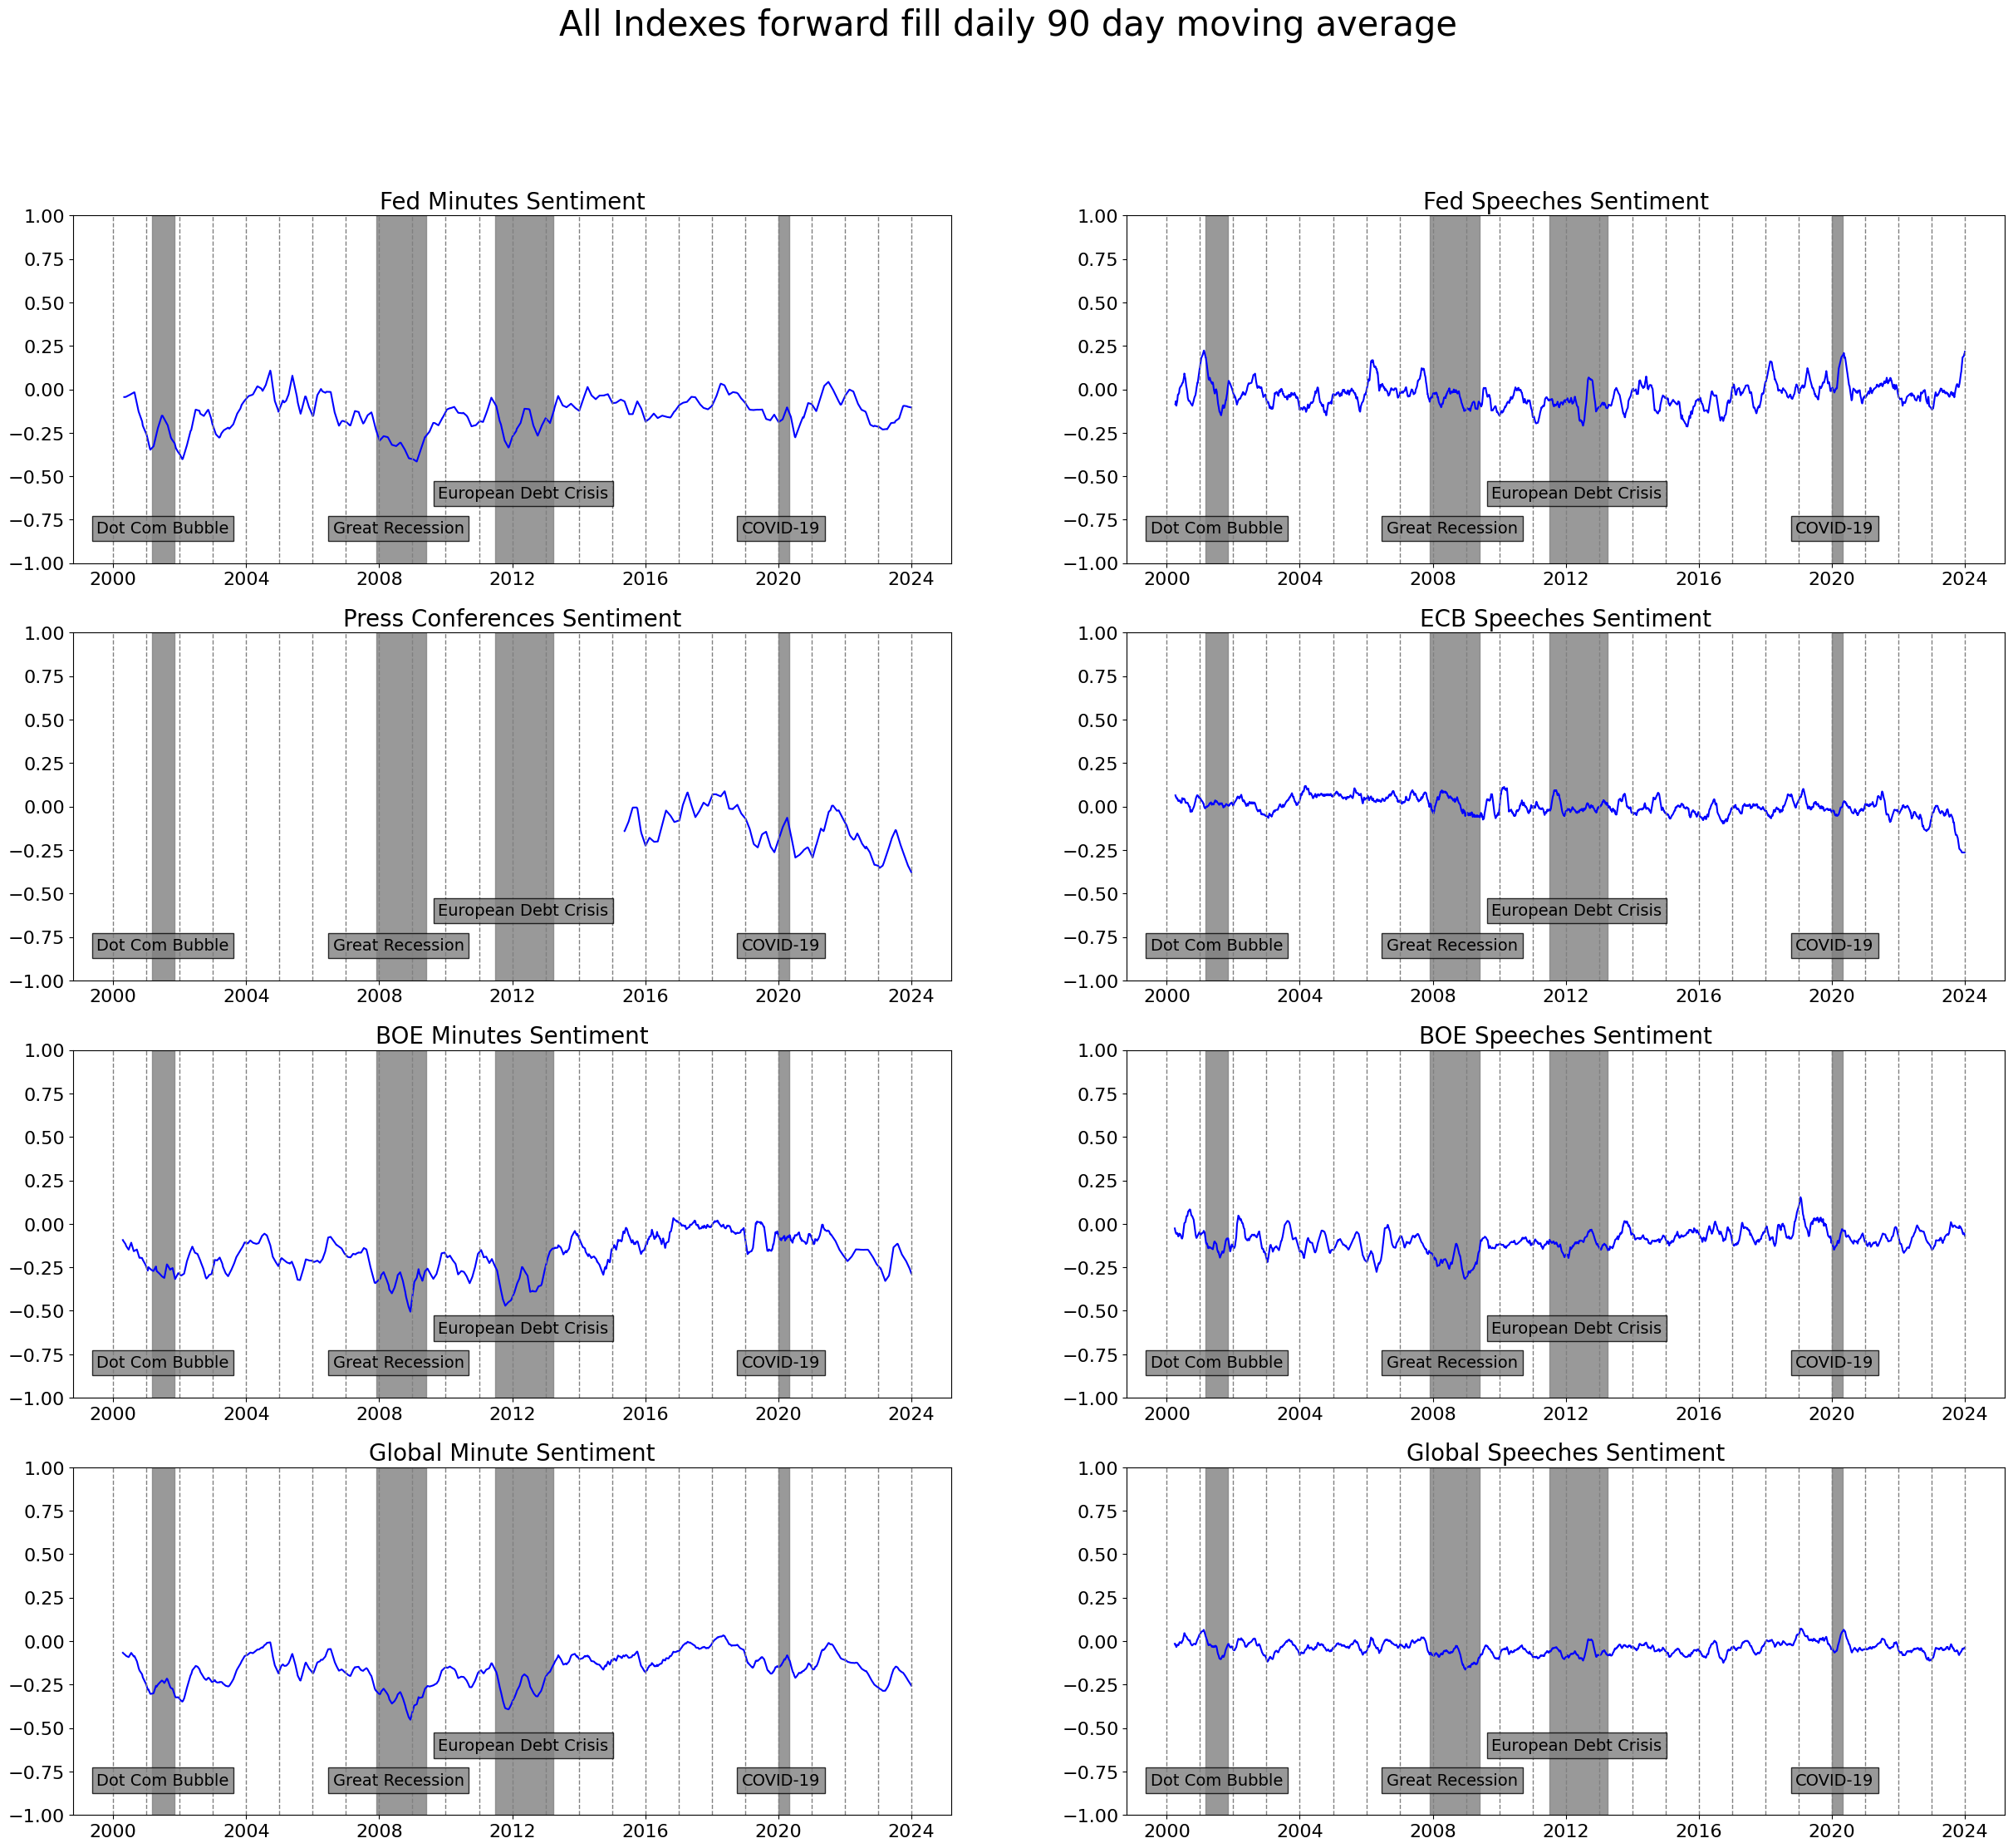

In [321]:
# Recreate the previous graph but using multiple subplots where every subplot is a different variable compared to the Taylor Rule
fig, ax = plt.subplots(4, 2, figsize=(30, 25))

# Add a big title at the top of the graphs
fig.suptitle("All Indexes forward fill daily 90 day moving average", fontsize=30)

min = -1
max = 1.01

# Define the variables to plot
variables = [
    "fed_minutes",
    "fed_speeches",
    "press_conferences",
    "ecb_speeches",
    "boe_minutes",
    "boe_speeches",
    "minute_sentiment",
    "speech_sentiment",
]

# Define the titles for each subplot
titles = [
    "Fed Minutes Sentiment",
    "Fed Speeches Sentiment",
    "Press Conferences Sentiment",
    "ECB Speeches Sentiment",
    "BOE Minutes Sentiment",
    "BOE Speeches Sentiment",
    "Global Minute Sentiment",
    "Global Speeches Sentiment",
]

# Plot each variable in the corresponding subplot
for i in range(4):
    for j in range(2):
        idx = i * 2 + j
        ax[i, j].plot(
            sentiment["date"],
            sentiment[variables[idx]],
            color="blue",
        )
        ax[i, j].set_title(titles[idx], fontsize=20)  # Adjust font size

yticks = np.arange(min, max, 0.25)  # Define yticks

for i in range(4):
    for j in range(2):
        ax[i, j].set_yticks(yticks)  # Set yticks
        ax[i, j].tick_params(axis="y", labelsize=16)  # Increase y-axis label font size
        ax[i, j].tick_params(axis="x", labelsize=16)  # Increase x-axis label font size

lh = -0.8
crisis_font = 14

# Create a vertical line at every year and highlight crises
for i in range(4):
    for j in range(2):
        for year in range(2000, 2025):
            ax[i, j].axvline(
                pd.to_datetime(f"{year}-01-01"), color="gray", linestyle="--", lw=1
            )

        # Great Recession
        ax[i, j].axvspan(
            pd.to_datetime("2007-12-01"),
            pd.to_datetime("2009-06-01"),
            color="gray",
            alpha=0.8,
        )
        ax[i, j].text(
            pd.to_datetime("2008-08-01"),
            lh,
            "Great Recession",
            horizontalalignment="center",
            verticalalignment="center",
            fontsize=crisis_font,  # Adjust font size
            bbox=dict(facecolor="gray", alpha=0.8),
        )

        # COVID
        ax[i, j].axvspan(
            pd.to_datetime("2020-01-01"),
            pd.to_datetime("2020-05-01"),
            color="gray",
            alpha=0.8,
        )
        ax[i, j].text(
            pd.to_datetime("2020-02-01"),
            lh,
            "COVID-19",
            horizontalalignment="center",
            verticalalignment="center",
            fontsize=crisis_font,  # Adjust font size
            bbox=dict(facecolor="gray", alpha=0.8),
        )

        # Dot Com Bubble
        ax[i, j].axvspan(
            pd.to_datetime("2001-03-01"),
            pd.to_datetime("2001-11-01"),
            color="gray",
            alpha=0.8,
        )
        ax[i, j].text(
            pd.to_datetime("2001-07-01"),
            lh,
            "Dot Com Bubble",
            horizontalalignment="center",
            verticalalignment="center",
            fontsize=crisis_font,  # Adjust font size
            bbox=dict(facecolor="gray", alpha=0.8),
        )

        # European Debt Crisis
        ax[i, j].axvspan(
            pd.to_datetime("2011-07-01"),
            pd.to_datetime("2013-04-01"),
            color="gray",
            alpha=0.8,
        )
        ax[i, j].text(
            pd.to_datetime("2012-05-01"),
            -0.6,
            "European Debt Crisis",
            horizontalalignment="center",
            verticalalignment="center",
            fontsize=crisis_font,  # Adjust font size
            bbox=dict(facecolor="gray", alpha=0.8),
        )

plt.show()

# Save the graph as a png file to /Users/kylenabors/Documents/Database/Photos
fig.savefig("/Users/kylenabors/Documents/Database/Photos/Sentiment Graph.png")

In [322]:
# Export the sentiment DataFrame as a CSV file
sentiment.to_csv(os.path.join(database, "sentiment_data.csv"), index=False)